## This notebook shows the code for modeling the death rate vs poverty rate in different US regions

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly, json
import plotly.express as px
from urllib.request import urlopen

sns.set_style("whitegrid")

In [15]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [16]:
# conda update -n base -c defaults conda

In [17]:
pip install plotly==5.11.0

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Get data for specific groups of people (you only want one data point per county when you plot)
import numpy as np
import pandas as pd
import plotly, json
import plotly.express as px
from urllib.request import urlopen

# Get county/mort stuff
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response: counties = json.load(response)
mort = pd.read_csv('.../mort_with_15yrpoverty.csv',dtype={"FIPS": str})

# This masks the unreliable data
mask = mort['Unreliable']==False
df = mort.loc[mask]

# The function
def flatten_df(df, filter_by = {}, save_fn = None): 
    
    sort_by = {'Gender Code' : None,
               'Race' : None,
               'Hispanic Origin' : None,
               'Interval' : None,
               'Age Group Code': None,
               'State' : None}
    county_level_cols = ['County','5_Year_Avg_Poverty_Estimate','Total 5yrAvg County Population',
                         'Total 5yrAvg County Population','Total 5yrAvg County Deaths',
                         'Total 5yrAvg State Population','Total 5yrAvg State Deaths',
                         'Total 15yrAvg County Population','Total 15yrAvg County Deaths',
                         'Total 15yrAvg State Population','Total 15yrAvg State Deaths']
    '''
    ,'CO 2nd Max 1-hr', 'CO 2nd Max 8-hr','NO2 98th Percentile 1-hr', 
    'NO2 Mean 1-hr', 'Ozone 2nd Max 1-hr', 'Ozone 4th Max 8-hr', 
    'SO2 99th Percentile 1-hr', 'SO2 2nd Max 24-hr','SO2 Mean 1-hr', 
    'PM2.5 98th Percentile 24-hr', 'PM2.5 Weighted Mean 24-hr', 
    'PM10 2nd Max 24-hr', 'Lead Max 3-Mo Avg',
    '''
    
    # Check for bad input
    for key in filter_by.keys(): 
        if key not in sort_by: 
            print('Unrecognized key in filter_by dict.')
            return
    
    for key in filter_by:
        if filter_by[key] != None: sort_by[key] = filter_by[key]
    
    # Remove all unnecesary data from the df
    temp_df = df.copy(deep=True)

    for key,val in sort_by.items():
        if val == None: 
            temp_df = temp_df.drop(columns=key)
        else:    
            temp_df = temp_df.loc[np.asarray(temp_df[key]==val)]
            
    # Flatten remaining data points so that there are no repeated counties/FIPS
    fips,ind = np.unique(temp_df['FIPS'],return_index=True)
    
    ### Get values that are constant for different groups in the same county
    county_levels = {}
    for col in county_level_cols:
        county_levels[col] = np.asarray(temp_df[col])[ind]
        
    ### Calculate the values that change with different groups in the same county
    deaths = []
    population = []
    for fip in fips:
        mask = np.asarray(temp_df['FIPS']==fip)
        single_county_df = temp_df.loc[mask]
        deaths.append(np.sum(single_county_df['Deaths']))
        population.append(np.sum(single_county_df['Population']))
    
    ### Calculate deaths and population per year
    if sort_by['Interval'] != None: num_years = 5
    else: num_years = 15
    deaths = np.asarray(deaths)/num_years
    population = np.asarray(population)/num_years
        
    flattened_df = pd.DataFrame(data={'FIPS': fips, 'Deaths': deaths, 'Population': population})
    for col in county_level_cols:
        flattened_df[col] = county_levels[col]
    
    # Save to CSV if necessary
    if save_fn != None:
        flattened_df.to_csv(save_fn)
    
    return flattened_df # dataframe with single row for each county containing deaths, population, poverty, and polution

In [19]:
# Select different time intervals (Int1=(2002-2006), Int2=(2007-2011), Int3=(2012-2016)):
mort_flattened = flatten_df(df,{'Interval':'2007-2011'})
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths
0,01001,406.2,28424.2,"Autauga County, AL",6157.0,32073.8,416.6,3357506.6,46468.6,32042.933333,436.133333,3.353935e+06,47131.000000
1,01003,1710.8,127456.8,"Baldwin County, AL",21396.8,132057.8,1715.2,3357506.6,46468.6,133171.666667,1722.066667,3.353935e+06,47131.000000
2,01005,251.4,11239.2,"Barbour County, AL",6933.2,13254.8,257.0,3357506.6,46468.6,13907.333333,267.600000,3.353935e+06,47131.000000
3,01007,191.6,9005.4,"Bibb County, AL",3990.6,12918.6,213.0,3357506.6,46468.6,12391.600000,215.466667,3.353935e+06,47131.000000
4,01009,532.4,32601.6,"Blount County, AL",8222.0,37696.4,542.2,3357506.6,46468.6,37446.000000,550.333333,3.353935e+06,47131.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,56037,214.8,20551.2,"Sweetwater County, WY",3258.6,24988.6,228.8,310783.2,3988.2,23872.066667,243.133333,3.062673e+05,4045.533333
3044,56039,57.8,4181.4,"Teton County, WY",1343.0,7428.6,65.4,310783.2,3988.2,8629.533333,71.000000,3.062673e+05,4045.533333
3045,56041,113.4,8202.2,"Uinta County, WY",1990.0,11809.2,121.8,310783.2,3988.2,10038.333333,117.866667,3.062673e+05,4045.533333
3046,56043,64.6,1362.4,"Washakie County, WY",891.4,2962.8,74.8,310783.2,3988.2,3246.066667,75.933333,3.062673e+05,4045.533333


## 1. US regions assignments: 

In [20]:
# Grouping the US states into different regions: West, Midwest, Northeast, South 
West = ['WA', 'OR','MT','ID','WY','CA','NV','UT','CO','AZ','NM', 'AK', 'HI']
Midwest = ['ND','SD','NE','KS','MN','IA','MD','WI','IL','MI','IN','OH', 'MO']
Northeast = ['PA','NY','NJ','CT','MA','RI','VT','NH','ME', 'DC']
South = ['TX','OK','AR','LA','MS','KY','TN','AL','WV','VA','NC','SC','GA','FL','MD','DE']

In [21]:
# Dictionary that maps states abbrev. to the regions 
dict_regions = {}
for state in West:
    dict_regions.update({state: 'West'})
for state in Midwest:
    dict_regions.update({state: 'Midwest'})
for state in Northeast:
    dict_regions.update({state: 'Northeast'})
for state in South:
    dict_regions.update({state: 'South'})

In [22]:
# Creating new columns for the rates, eliminating zeros and ones in the data 
mort_flattened.loc[:,'PovertyRate'] = mort_flattened.loc[:,'5_Year_Avg_Poverty_Estimate']/mort_flattened.loc[:,'Population']
mort_flattened.loc[:,'DeathRate'] = (mort_flattened.loc[:,'Deaths']/mort_flattened.loc[:,'Population'])
mort_flattened2 = mort_flattened[mort_flattened.PovertyRate<=1].reset_index(drop=True)
mort_flattened_log = mort_flattened2[~((mort_flattened2.DeathRate==0) | (mort_flattened2.PovertyRate==0))]

# Extract the states abbrev. into a new column to facilitate sorting latter   
mort_flattened.loc[:,'State'] = mort_flattened.loc[:,'County'].apply(lambda x: x.split(',')[1][1:])

# Assign a region based on the state abbrev. using the previous dictionary 
mort_flattened.loc[:,'Region'] = mort_flattened.loc[:,'State'].apply(lambda x: dict_regions.get(x))

In [31]:
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths,PovertyRate,DeathRate,State,Region
0,01001,406.2,28424.2,"Autauga County, AL",6157.0,32073.8,416.6,3357506.6,46468.6,32042.933333,436.133333,3.353935e+06,47131.000000,0.216611,0.014291,AL,South
1,01003,1710.8,127456.8,"Baldwin County, AL",21396.8,132057.8,1715.2,3357506.6,46468.6,133171.666667,1722.066667,3.353935e+06,47131.000000,0.167875,0.013423,AL,South
2,01005,251.4,11239.2,"Barbour County, AL",6933.2,13254.8,257.0,3357506.6,46468.6,13907.333333,267.600000,3.353935e+06,47131.000000,0.616877,0.022368,AL,South
3,01007,191.6,9005.4,"Bibb County, AL",3990.6,12918.6,213.0,3357506.6,46468.6,12391.600000,215.466667,3.353935e+06,47131.000000,0.443134,0.021276,AL,South
4,01009,532.4,32601.6,"Blount County, AL",8222.0,37696.4,542.2,3357506.6,46468.6,37446.000000,550.333333,3.353935e+06,47131.000000,0.252196,0.016330,AL,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,56037,214.8,20551.2,"Sweetwater County, WY",3258.6,24988.6,228.8,310783.2,3988.2,23872.066667,243.133333,3.062673e+05,4045.533333,0.158560,0.010452,WY,West
3044,56039,57.8,4181.4,"Teton County, WY",1343.0,7428.6,65.4,310783.2,3988.2,8629.533333,71.000000,3.062673e+05,4045.533333,0.321184,0.013823,WY,West
3045,56041,113.4,8202.2,"Uinta County, WY",1990.0,11809.2,121.8,310783.2,3988.2,10038.333333,117.866667,3.062673e+05,4045.533333,0.242618,0.013826,WY,West
3046,56043,64.6,1362.4,"Washakie County, WY",891.4,2962.8,74.8,310783.2,3988.2,3246.066667,75.933333,3.062673e+05,4045.533333,0.654287,0.047416,WY,West


## 2. Modeling: -Regression fit and log-log fit-

The next plot shows the scatter data for region: South


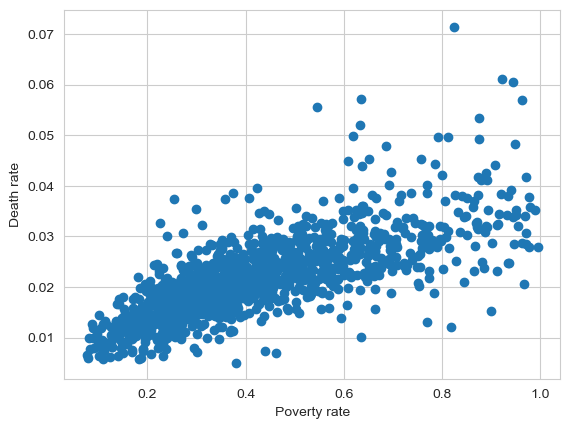

For region South : Log coeff [ 0.59414337 -1.44321827] Lin coeff [0.02992692 0.00895747]


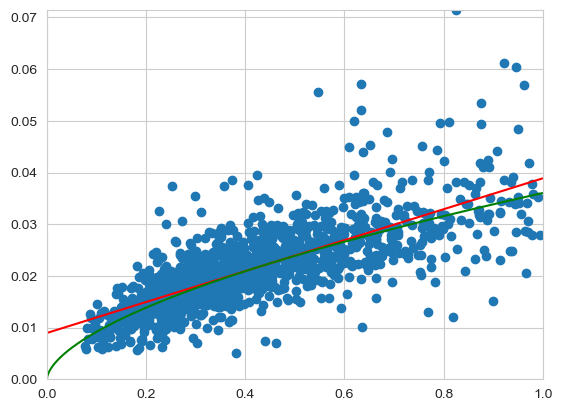

The r2 score for the linear fit is 0.7437428266387429
The r2 score for the log fit is 0.7473066644044196
The next plot shows the scatter data for region: West


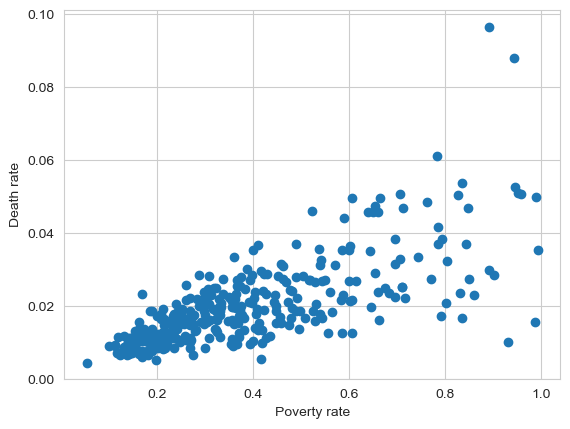

For region West : Log coeff [ 0.74112146 -1.40636341] Lin coeff [0.04113067 0.00420936]


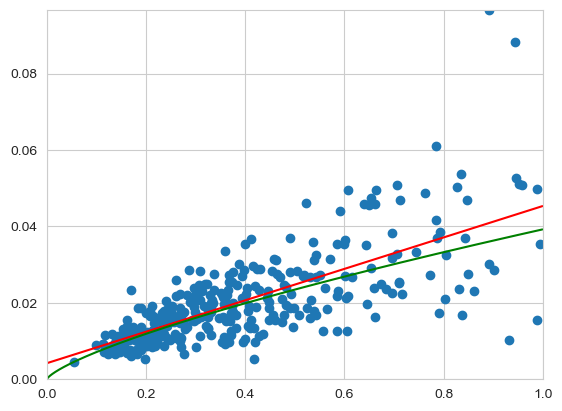

The r2 score for the linear fit is 0.7263970718470202
The r2 score for the log fit is 0.7130888521931011
The next plot shows the scatter data for region: Northeast


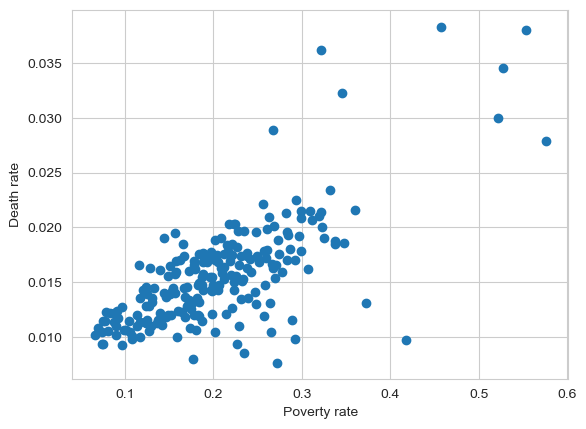

For region Northeast : Log coeff [ 0.44479811 -1.50307289] Lin coeff [0.04078979 0.00720098]


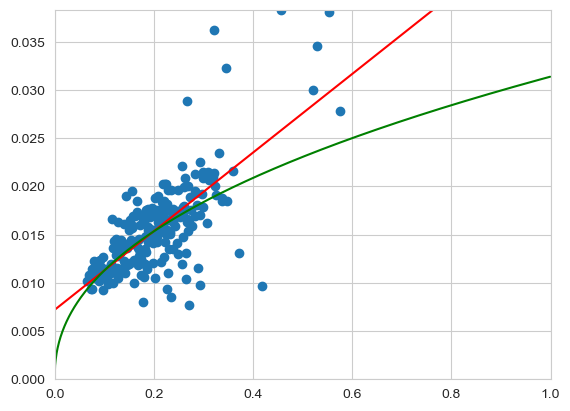

The r2 score for the linear fit is 0.7192109399360358
The r2 score for the log fit is 0.6776389350217346
The next plot shows the scatter data for region: Midwest


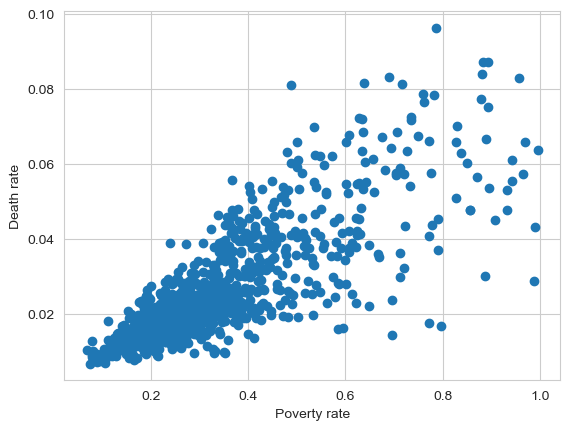

For region Midwest : Log coeff [ 0.8465596  -1.19556393] Lin coeff [0.06835578 0.00319798]


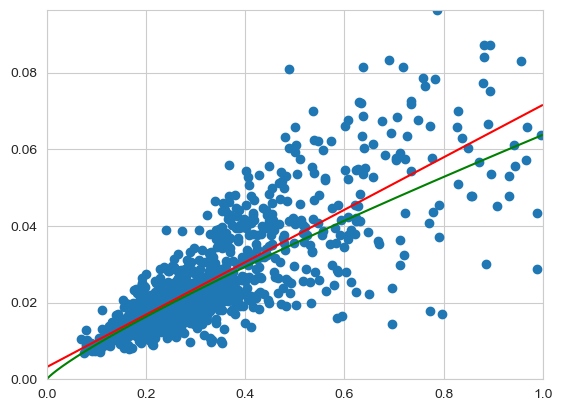

The r2 score for the linear fit is 0.7963151566524365
The r2 score for the log fit is 0.7892900548951202


<Figure size 640x480 with 0 Axes>

In [24]:
# This section plots, fits and calculates the r_2 values for each region in the US 

# Dictionaries that store the polynomial coefficients and log-log fit coefficients 
log_pol_coefs = {}
lin_pol_coefs = {}

# Loop through each region to get the best linear fit and log-log fit 
for region in mort_flattened.Region.drop_duplicates():
    print("The next plot shows the scatter data for region:", region)
    # Removes zeros and ones from the dataframe, plots the scatter data for each region
    mort_flattened_reg = mort_flattened[mort_flattened.Region == region].reset_index(drop=True)
    mort_flattened_2 = mort_flattened_reg[~(mort_flattened_reg.PovertyRate>=1)].reset_index(drop=True)
    mort_flattened_log = mort_flattened_2[~((mort_flattened_2.DeathRate==0) | (mort_flattened_2.PovertyRate==0))]
    mort_flattened_log = mort_flattened_log.dropna().reset_index(drop=True)
    mort_flattened_2 = mort_flattened_2.dropna().reset_index(drop=True)
    plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
    plt.xlabel("Poverty rate")
    plt.ylabel("Death rate")
    plt.show()
    plt.clf()

    # Calculates the linear regression coefficients
    y = np.log10(mort_flattened_log.DeathRate)
    x = np.log10(mort_flattened_log.PovertyRate)
    poly_coef_log = np.polyfit(x,y,1)
    
    # Calculates the log-log fit coefficients
    y_2 = mort_flattened_2.DeathRate
    x_2 = mort_flattened_2.PovertyRate
    poly_coef_lin = np.polyfit(x_2,y_2,1)
    print("For region", region, ":","Log coeff", poly_coef_log, "Lin coeff", poly_coef_lin)
    
    #Storing the coefficients in the dictionary 
    log_pol_coefs[region] = poly_coef_log
    lin_pol_coefs[region] = poly_coef_lin
    
    # Plotting best fit lines using the coefficients calculated previously 
    xfit = np.arange(-10,2,0.1)
    yfit = np.polyval(poly_coef_log,xfit)
    xfit2 = np.arange(0,1,0.001)
    yfit2 = np.polyval(poly_coef_lin,xfit2)
    yfit3 = 10**(poly_coef_log[1]) * xfit2**(poly_coef_log[0])
    ymax= max(y_2)

    # Plotting the fits onto the scatter data 
    plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
    plt.plot(xfit2,yfit2, color='red')
    plt.plot(xfit2,yfit3, color='green')
    plt.xlim(0,1)
    plt.ylim(0,ymax)
    plt.show()
    plt.clf()

    # Gives an r-score for the linear fit 
    from sklearn.metrics import r2_score
    r2_log = np.sqrt(r2_score(y_2,10**(poly_coef_log[1]) * x_2**(poly_coef_log[0])))
    r2_lin = np.sqrt(r2_score(y_2,np.polyval(poly_coef_lin,x_2)))
    print( "The r2 score for the linear fit is", r2_lin)
    print( "The r2 score for the log fit is", r2_log)

## 3. Plots of the US regions for different time intervals 

(0.0, 0.1)

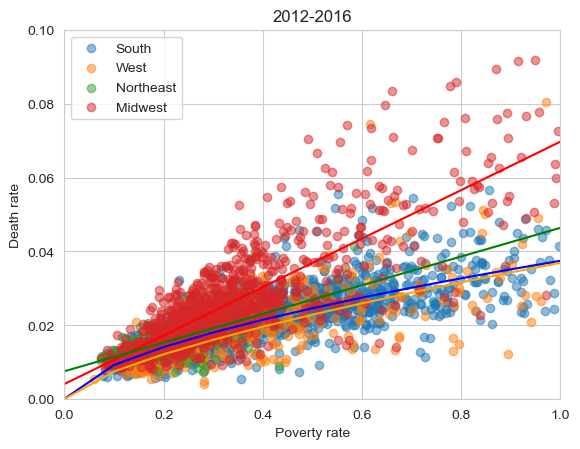

In [19]:
# This section plots all the regions plus their best fit lines into one final plot 
# Scatter plot of all regions and their best fit lines in a graph  
fig = plt.figure()
ax = plt.gca()

for region in mort_flattened.Region.drop_duplicates():
    s = ax.scatter(mort_flattened[mort_flattened.Region==region].PovertyRate, mort_flattened[mort_flattened.Region==region].DeathRate, alpha=0.5)
    s.set_label(region)    
    
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,0.1)
plt.xlabel("Poverty rate")
plt.ylabel("Death rate")
plt.title("2012-2016")

# The best fit is linear in the Midwest and Northeast, log in the South and West
xfit = np.arange(0.0001,2,0.1)
yfit_s = np.polyval(log_pol_coefs.get('South'),np.log10(xfit))
yfit_w = np.polyval(log_pol_coefs.get('West'),np.log10(xfit))
yfit_m = np.polyval(lin_pol_coefs.get('Midwest'),xfit)
yfit_n = np.polyval(lin_pol_coefs.get('Northeast'),xfit)

# plotting the best fit lines
ax.plot(xfit,yfit_m, color='red')
ax.plot(xfit,yfit_n, color='green')
ax.plot(xfit,10**yfit_s, color='blue')
ax.plot(xfit,10**yfit_w, color='orange')

plt.xlim(0,1)
plt.ylim(0,0.1)
# plt.savefig('.../2012-2016USRegions_relfitdata.png')

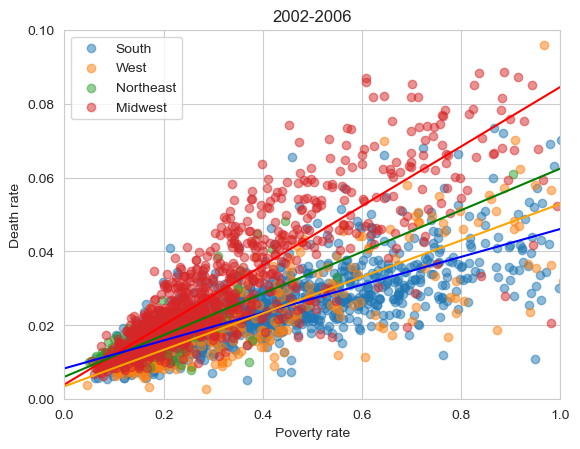

In [237]:
# Scatter plot of all regions and their best fit lines in a graph  
fig = plt.figure()
ax = plt.gca()

for region in mort_flattened.Region.drop_duplicates():
    s = ax.scatter(mort_flattened[mort_flattened.Region==region].PovertyRate, mort_flattened[mort_flattened.Region==region].DeathRate, alpha=0.5)
    s.set_label(region)    
    
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,0.1)
plt.xlabel("Poverty rate")
plt.ylabel("Death rate")
plt.title("2002-2006")

# The best fit is linear in the South, West, Northeast, Midwest
xfit = np.arange(0.0001,2,0.1)
yfit_s = np.polyval(lin_pol_coefs.get('South'),xfit)
yfit_w = np.polyval(lin_pol_coefs.get('West'),xfit)
yfit_m = np.polyval(lin_pol_coefs.get('Midwest'),xfit)
yfit_n = np.polyval(lin_pol_coefs.get('Northeast'),xfit)

# plotting the best fit lines
ax.plot(xfit,yfit_m, color='red')
ax.plot(xfit,yfit_n, color='green')
ax.plot(xfit,yfit_s, color='blue')
ax.plot(xfit,yfit_w, color='orange')

plt.xlim(0,1)
plt.ylim(0,0.1)
# plt.savefig('.../2002-2006USRegions_relfitdata.png')

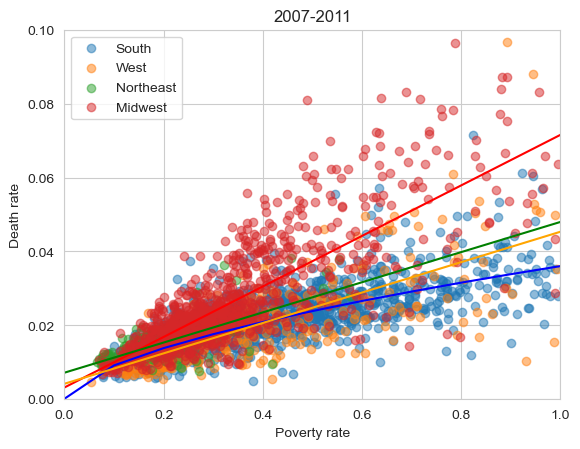

In [243]:
# Scatter plot of all regions and their best fit lines in a graph  
fig = plt.figure()
ax = plt.gca()

for region in mort_flattened.Region.drop_duplicates():
    s = ax.scatter(mort_flattened[mort_flattened.Region==region].PovertyRate, mort_flattened[mort_flattened.Region==region].DeathRate, alpha=0.5)
    s.set_label(region)    
    
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,0.1)
plt.xlabel("Poverty rate")
plt.ylabel("Death rate")
plt.title("2007-2011")

# The best fit is linear in the West, Northeast, Midwest, log in the South 
xfit = np.arange(0.0001,2,0.1)
yfit_s = np.polyval(log_pol_coefs.get('South'),np.log10(xfit))
yfit_w = np.polyval(lin_pol_coefs.get('West'),xfit)
yfit_m = np.polyval(lin_pol_coefs.get('Midwest'),xfit)
yfit_n = np.polyval(lin_pol_coefs.get('Northeast'),xfit)

# plotting the best fit lines
ax.plot(xfit,yfit_m, color='red')
ax.plot(xfit,yfit_n, color='green')
ax.plot(xfit,10**yfit_s, color='blue')
ax.plot(xfit,yfit_w, color='orange')

plt.xlim(0,1)
plt.ylim(0,0.1)
# plt.savefig('.../2007-2011USRegions_relfitdata.png')

Calculating the best fits for each US region 

In [74]:
plt.close()

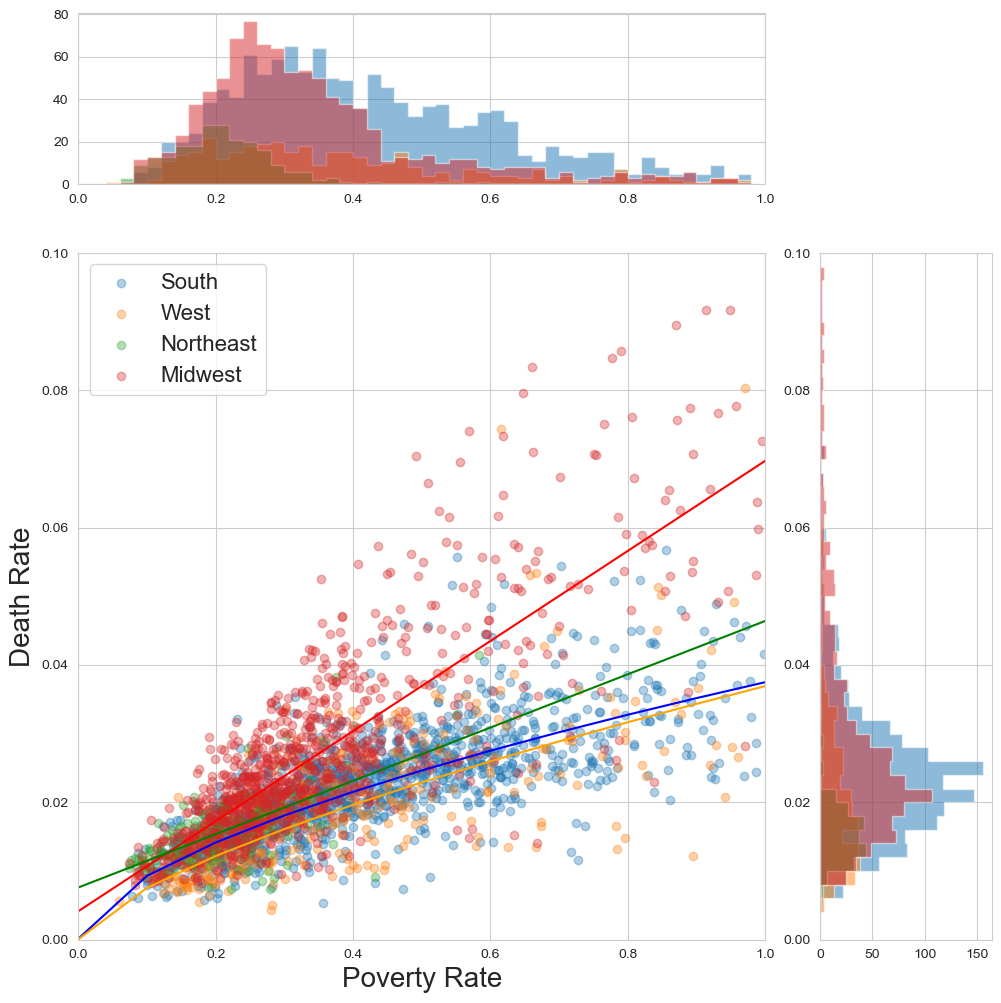

In [18]:
# This section creates a multi-axis plot showing scatter data plus two histograms showing the distribution of x-axis and y-axis  

# Create a Figure, which doesn't have to be square.
fig = plt.figure(constrained_layout=True,figsize=(10,10))
# Create the main axis, leaving 25% of the figure space at the top and on the right to position marginals.
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect='auto')
# Create marginal axes, which have 25% of the size of the main axes.  Note that the inset axes are positioned *outside* (on the right and the top) of the main axes, 
# by specifying axes coordinates greater than 1.  Axes coordinatesless than 0 would likewise specify positions on the left and the bottom of the main axes.
ax_histx = ax.inset_axes([0, 1.1, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.08, 0, 0.25, 1], sharey=ax)

#Lists stored the sorted values of x and y variables depending for each region separately, region label as well  
xdata = []
ydata = []
region_label = []
for region in mort_flattened.Region.drop_duplicates():
    #Plot scatter in the main axis 
    s = ax.scatter(mort_flattened[mort_flattened.Region==region].PovertyRate, mort_flattened[mort_flattened.Region==region].DeathRate, alpha=0.35)
    s.set_label(region)    
    #Plot histogram data on the top axis 
    xdata.append(np.array(mort_flattened[mort_flattened.Region==region].PovertyRate))
    ax_histx.hist(mort_flattened[mort_flattened.Region==region].PovertyRate, bins=np.arange(0,1,0.02), stacked=True, alpha=0.5, label=region, histtype='stepfilled' )
    region_label.append(region)
    #Plot histogram data on the right axis 
    ydata.append(np.array(mort_flattened[mort_flattened.Region==region].DeathRate))
    ax_histy.hist(mort_flattened[mort_flattened.Region==region].DeathRate, bins=np.arange(0,0.1,0.002), stacked=True, alpha=0.5, label=region, histtype='stepfilled', 
                  orientation= 'horizontal' )
    region_label.append(region)
    
# Set up labels and axis limits 
ax.legend(fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,0.1)
plt.xlabel("Poverty rate", fontsize=16)
plt.ylabel("Death rate", fontsize=16)
ax.set_xlabel('Poverty Rate',fontsize=20)
ax.set_ylabel('Death Rate',fontsize=20)

# Plots the best fit on the scatter data 
xfit = np.arange(0.0001,2,0.1)
yfit_s = np.polyval(log_pol_coefs.get('South'),np.log10(xfit))
yfit_w = np.polyval(log_pol_coefs.get('West'),np.log10(xfit))
yfit_m = np.polyval(lin_pol_coefs.get('Midwest'),xfit)
yfit_n = np.polyval(lin_pol_coefs.get('Northeast'),xfit)

# Plots the best fits on the main axis 
ax.plot(xfit,yfit_m, color='red')
ax.plot(xfit,yfit_n, color='green')
ax.plot(xfit,10**yfit_s, color='blue')
ax.plot(xfit,10**yfit_w, color='orange')

plt.show()


In [182]:
# This section plots the regions in colors in a US map  
import plotly.express as px

dfstates = mort_flattened[['State', 'Region']].drop_duplicates().reset_index(drop=True)
lstStates = list(mort_flattened.State.drop_duplicates())
fig = px.choropleth(locations=np.array(dfstates.State), locationmode="USA-states", color=np.array(dfstates.Region), scope="usa", 
                                       color_discrete_map={'South': 'blue', 'Northeast': 'green', 'Midwest': 'red', 'West': 'orange'})
fig.write_image('USmap_regions.png')

__________________________________________________________________________________________________________________________________________
END OF MAIN SECTION 
------------------------------------------------------------------------------------------------------------------------------------------

<!-- The following extra notes on the log-log fit  -->